<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Developing a classification model for Twitter topics (Formula 1 vs MotoGP)

### Contents:
- [Modeling and Evaluation (Logistic Regression)](#Modeling-and-Evaluation-(Logistic-Regression))

## Modeling and Evaluation (Logistic Regression)

In this section we will build a Logistic Regression model, which derives the probability of an outcome as a function of a number of predictor variables. In this context, we are deriving the probability of a tweet having F1 related content.

Although our Naive Bayes model (refer to notebook 4A) has achieved high scores, it is good to have a different model to compare the results and assess if the first model is accurate.

We will adopt the following approach in our model building:

1. Build a model (M1) using tweet as feature and evaluate the model.
2. Build a model (M2)  using hashtag as feature and evaluate the model.
3. If hashtag is overly dominant as a predictor, re-evaluate performance of M1 on tweets excluding hashtag/mentions.
4. Try to improve M1 by incorporating other features such as tweet length, tweet word count, number of likes, and number of retweets.
5. Determine best threshold to maximize recall and F1 scores.

Rationale behind approach:
As our data was scrapped from the official accounts of Formula 1 and MotoGP, 97% of tweets included hashtags to other official accounts such as the drivers or the constructor teams. However, our aim is to create a classifier that will recommend Formula 1 related tweets from anyone to users who have chosen to follow the topic of Formula 1. Individual users are less likely to include hashtags or mentions as they are not as strictly managed as official accounts. Hence, we want to make sure our model works sufficiently well for tweets that do not have any hashtag or mention. 

Since our aim is to accurately provide Formula 1 related tweets to the news feeds of interested users, we will be focusing on maximizing recall, so that we will capture as many of the actual related tweets as possible. However, we do not want our model to be predicting all tweets as Formula 1 related, which would give us 100% recall but also super low precision. Hence we will try to maximize recall while maintaining a good ROC AUC score, which reflects how well the model is able to separate the classes.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in file
df = pd.read_csv("../data/train_data_cleaned.csv")
df.head()

,tweet,text,hashtag,mention,username,like_count,retweet_count,tweet_length,tweet_word_count
0,tension running high team principal group meet...,tension running high team principal group meet...,f1 drivetosurvive5,netflix,F1,22499,1637,181,27
1,"striking pose , ft. glorious mullet followed @...","striking pose , ft. glorious mullet followed p...",f1,valtteribottas alfaromeof1,F1,3553,291,243,45
2,fantasy price reveal create ultimate team ahea...,fantasy price reveal create ultimate team ahea...,f1 f1fantasy,NaN,F1,1527,146,132,23
3,almost time f1 fantasy restart ! tip get # f1f...,almost time f1 fantasy restart ! tip get team ...,f1fantasy f1,NaN,F1,1215,210,164,30
4,put two together ! @ pierregasly good pal @ yu...,put two together ! good pal,f1,pierregasly yukitsunoda07,F1,8125,785,114,16


In [3]:
# Create outcome variable
df['f1'] = df['username'].map({'F1':1, 'MotoGP':0})
df['f1'].value_counts()

0    11676
1     8173
Name: f1, dtype: int64

### Logistic Regression using tweet as feature

In [4]:
# Select text feature
df_tweet = df.dropna(subset=['tweet'])
df_tweet['f1'].value_counts()

0    11672
1     8147
Name: f1, dtype: int64

In [5]:
# Train-test split for modeling
X1 = df_tweet[['tweet','text','like_count','retweet_count','tweet_length','tweet_word_count']]
y1 = df_tweet['f1']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y1)

In [6]:
# Instantiate CountVectorizer.
cv = CountVectorizer(stop_words = 'english', min_df = 10)

In [7]:
# Fit our CountVectorizer on the training data and transform training data.
X1_train_tweet_cv = pd.DataFrame(cv.fit_transform(X1_train['tweet']).todense(),
                          columns = cv.get_feature_names())
X1_train_tweet_cv.head()

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,10,100,10th,11,11th,12,12th,13,13th,...,young,youngest,youtube,yuki,yukitsunoda07,zandvoort,zarco,zhou,zhouguanyu24,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Transform our testing data with the already-fit CountVectorizer.
X1_test_tweet_cv = pd.DataFrame(cv.transform(X1_test['tweet']).todense(),
                         columns = cv.get_feature_names())

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Instantiate Log Reg model
lr = LogisticRegression()

# Fit model
M1 = lr.fit(X1_train_tweet_cv, y1_train)

In [10]:
# Score model on the training set.
M1.score(X1_train_tweet_cv, y1_train)

0.9954924650161464

In [11]:
# Create function to evaluate model based on accuracy, recall, precision, f1-score
def evaluate_model(X_test,y_test,threshold,model):
    
    prob = model.predict_proba(X_test)
    pred = (prob[:, 1] >= threshold).astype(int)
    
    #derive confusion matrix
    cm = confusion_matrix(y_test,pred)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # calculate accuracy
    accuracy = (tn + tp) / (tn + fp + fn + tp)

    # calculate recall
    recall = tp / (tp + fn)

    # calculate precision
    precision = tp / (tp + fp)

    # calculate F1 score
    f1_score = 2 * (precision*recall) / (precision + recall)

    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['MotoGP', 'F1']);
    print("Accuracy: {}".format(accuracy))
    print("Recall: {}".format(recall))
    print("Precision: {}".format(precision))
    print("F1 Score: {}".format(f1_score))

Accuracy: 0.9917255297679112
Recall: 0.9803632793323515
Precision: 0.9994994994994995
F1 Score: 0.9898389095415118


/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


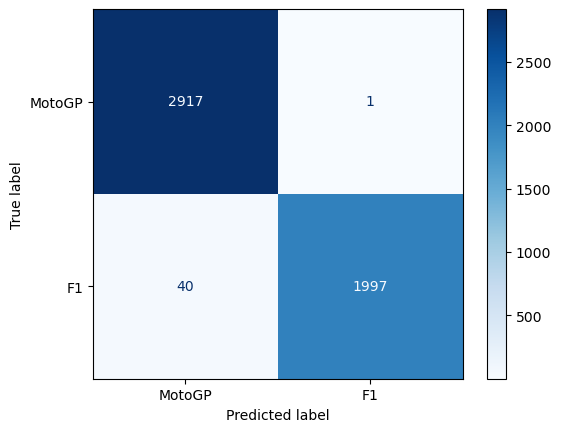

In [12]:
# Evaluate Model
evaluate_model(X1_test_tweet_cv, y1_test, 0.5, M1)

#### M1 has high accuracy, recall, precision, and F1 score. Confusion matrix shows that there were very few Type I and II errors in the predictions.

### Logistic Regression using hashtag as feature

In [13]:
# Select text feature
df_hashtag = df.dropna(subset=['hashtag'])
df_hashtag['f1'].value_counts()

0    11332
1     7922
Name: f1, dtype: int64

In [14]:
# Train-test split for modeling
X2 = df_hashtag[['hashtag']]
y2 = df_hashtag['f1']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                    y2,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y2)

In [15]:
# Instantiate CountVectorizer.
cv = CountVectorizer(stop_words = 'english', min_df = 10)

In [16]:
# Fit our CountVectorizer on the training data and transform training data.
X2_train_hashtag_cv = pd.DataFrame(cv.fit_transform(X2_train['hashtag']).todense(),
                          columns = cv.get_feature_names())

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# Transform our testing data with the already-fit CountVectorizer.
X2_test_hashtag_cv = pd.DataFrame(cv.transform(X2_test['hashtag']).todense(),
                         columns = cv.get_feature_names())

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
# Instantiate Log Reg model
lr = LogisticRegression()

# Fit model
M2 = lr.fit(X2_train_hashtag_cv, y2_train)

In [19]:
# Score model on the training set.
M2.score(X2_train_hashtag_cv, y2_train)

0.9914819944598338

In [20]:
# Score model on the testing set.
M2.score(X2_test_hashtag_cv, y2_test)

0.9910677191524719

Accuracy: 0.9910677191524719
Recall: 0.9782937910146391
Precision: 1.0
F1 Score: 0.9890278132176576


/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


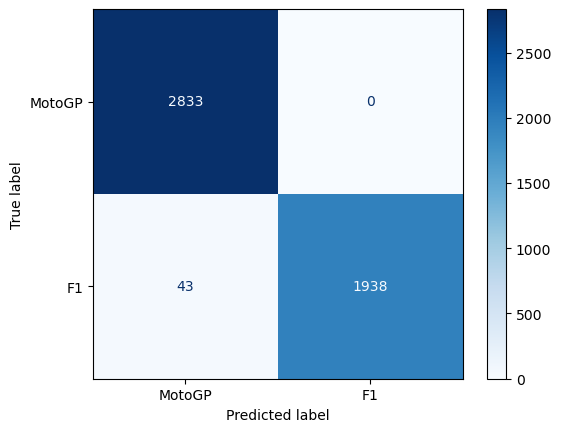

In [21]:
# Evaluate Model
evaluate_model(X2_test_hashtag_cv, y2_test, 0.5, M2)

#### Similar to M1, M2 has high accuracy, recall, precision, and F1 score. Confusion matrix shows that there were zero Type 1 error and very few Type II errors in the predictions. This implies that the performance of M1 could have been greatly influenced by hashtags, which might hinder its performance for tweets without hashtags.

### Evaluate M1 on text-only tweets

In [22]:
# Select text feature
df_text = pd.DataFrame({'text': X1_test['text'], 'f1':y1_test})
df_text = df_text.dropna(subset='text')
df_text.shape

(4943, 2)

In [23]:
# Instantiate CountVectorizer.
cv = CountVectorizer(stop_words = 'english', min_df = 10)

In [24]:
# Fit our CountVectorizer on the training data and transform training data.
X1_train_tweet_cv = pd.DataFrame(cv.fit_transform(X1_train['tweet']).todense(),
                          columns = cv.get_feature_names())

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
X1_train_tweet_cv.head()

,00,10,100,10th,11,11th,12,12th,13,13th,...,young,youngest,youtube,yuki,yukitsunoda07,zandvoort,zarco,zhou,zhouguanyu24,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Transform our testing data with the already-fit CountVectorizer.
X1_test_text_cv = pd.DataFrame(cv.transform(df_text['text']).todense(),
                         columns = cv.get_feature_names())

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
# Create target variable
y1_test_text = df_text['f1']

In [28]:
# Score model on the training set.
M1.score(X1_train_tweet_cv, y1_train)

0.9954924650161464

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.7720008092251669
Recall: 0.4533793783917119
Precision: 0.9797441364605544
F1 Score: 0.6198988195615515


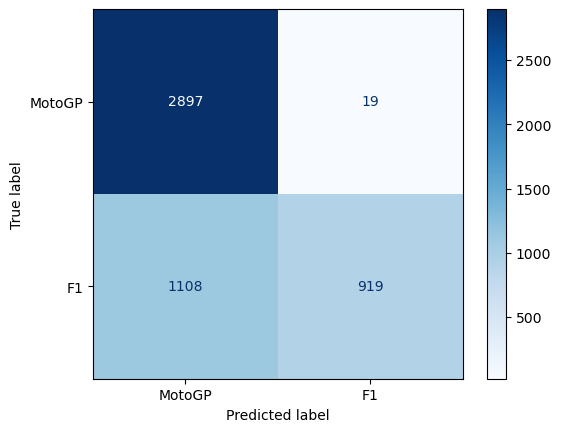

In [29]:
evaluate_model(X1_test_text_cv, y1_test_text, 0.5, M1)

#### M1 performance dropped when applied to text-only tweets, with accuracy dropping from 99% to 77%. Recall rates also dropped form 98% to 45%. We will try to improve M1's performance on text-only tweets by incorporating additional features.

### Retraining M1 with additional features

In [30]:
# Separate non-text features on training set
X1_train_add = X1_train.drop(columns=['tweet','text'])
X1_train_add.shape

(14864, 4)

In [31]:
# Tokenize text features on training set

# Instantiate CountVectorizer.
cv = CountVectorizer(stop_words = 'english', min_df = 10)
X1_tweet = cv.fit_transform(X1_train['tweet'])
X1_tweet

<14864x1956 sparse matrix of type '<class 'numpy.int64'>'
	with 128170 stored elements in Compressed Sparse Row format>

In [32]:
# Combine all features for training set
X1_train_all = np.column_stack((X1_tweet.toarray(),X1_train_add))
X1_train_all

array([[  0,   0,   0, ...,  32, 179,  29],
       [  0,   0,   0, ...,  67, 123,  24],
       [  0,   0,   0, ..., 313, 131,  18],
       ...,
       [  0,   0,   0, ...,  19, 175,  27],
       [  0,   0,   0, ..., 507,  67,  10],
       [  0,   0,   0, ..., 119, 111,  14]])

In [33]:
# Separate non-text features on testing set
X1_test_add = X1_test.dropna()
X1_test_add = X1_test_add.drop(columns=['tweet','text'])
X1_test_add.shape

(4943, 4)

In [34]:
# Tokenize text features on testing set
X1_text = cv.transform(df_text['text'])
X1_text

<4943x1956 sparse matrix of type '<class 'numpy.int64'>'
	with 31528 stored elements in Compressed Sparse Row format>

In [35]:
# Combine all features for testing set
X1_test_all = np.column_stack((X1_text.toarray(),X1_test_add))
X1_test_all

array([[  0,   0,   0, ...,  51,  59,   8],
       [  0,   0,   0, ...,  81, 156,  26],
       [  0,   0,   0, ..., 102,  87,  13],
       ...,
       [  0,   0,   0, ..., 172, 204,  23],
       [  0,   0,   0, ...,  20,  91,  13],
       [  0,   0,   0, ...,  30, 189,  30]])

In [36]:
# Instantiate Log Reg model
lr = LogisticRegression()

# Fit model
M3 = lr.fit(X1_train_all, y1_train)

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Score model on the training set.
M3.score(X1_train_all, y1_train)

0.9927341227125942

Accuracy: 0.8889338458426057
Recall: 0.7335964479526393
Precision: 0.9939839572192514
F1 Score: 0.8441669032074935


/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


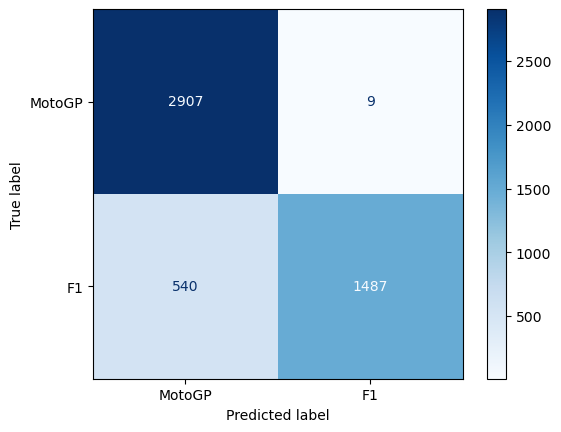

In [38]:
# Evaluate model
evaluate_model(X1_test_all, y1_test_text, 0.5, M3)

#### After incorporating additional features, model performance improved again. M3's accuracy increased to 89% on text-only tweets and recall increased to 73%, compared to 77% and 45% respectively for M1.

### Evaluate M3 on tweets

In [39]:
# Separate non-text features
X1_test_add_tweet = X1_test.drop(columns=['tweet','text'])
X1_test_add_tweet.shape

(4955, 4)

In [40]:
# Tokenize text features
X1_test_tweet = cv.transform(X1_test['tweet'])
X1_test_tweet

<4955x1956 sparse matrix of type '<class 'numpy.int64'>'
	with 42677 stored elements in Compressed Sparse Row format>

In [41]:
# Combine all features
X1_test_all_tweet = np.column_stack((X1_test_tweet.toarray(),X1_test_add_tweet))
X1_test_all_tweet

array([[  0,   0,   0, ...,  51,  59,   8],
       [  0,   0,   0, ...,  81, 156,  26],
       [  0,   0,   0, ..., 102,  87,  13],
       ...,
       [  0,   0,   0, ..., 172, 204,  23],
       [  0,   0,   0, ...,  20,  91,  13],
       [  0,   0,   0, ...,  30, 189,  30]])

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9927346115035318
Recall: 0.9833087874324987
Precision: 0.999002493765586
F1 Score: 0.9910935180603662


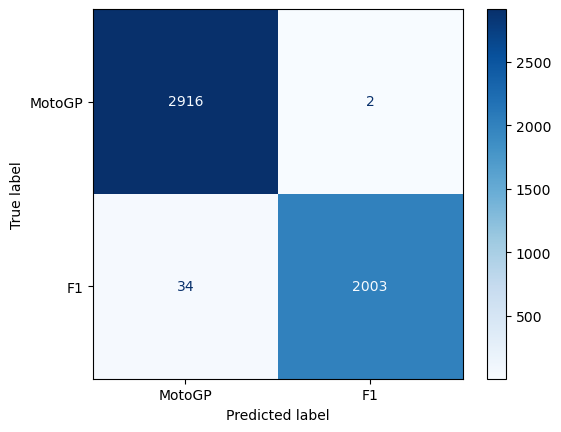

In [42]:
# Evaluate model
evaluate_model(X1_test_all_tweet, y1_test, 0.5, M3)

M3 showed accuracy of 99% and recall rate of 98% on tweets, back to similar levels as M1.

#### Checking ROC AUC for text-only tweet prediction

In [43]:
prob_text=M3.predict_proba(X1_test_all)
prob_text

array([[0.91737622, 0.08262378],
       [0.683553  , 0.316447  ],
       [0.21814527, 0.78185473],
       ...,
       [0.30271096, 0.69728904],
       [0.87939606, 0.12060394],
       [0.98212878, 0.01787122]])

In [44]:
df_test_text=pd.DataFrame({'f1': y1_test_text, 'prob': prob_text[:,1]})
df_test_text.head()

,f1,prob
13367,0,0.082624
2422,1,0.316447
3546,1,0.781855
5260,1,0.291409
7152,1,0.946021


/var/folders/3n/fkv2x4vs6_jc1rvhs53fssxr0000gn/T/ipykernel_2076/3692339015.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


Text(0.5, 1.0, 'Probabilities vs Actual Outcome')

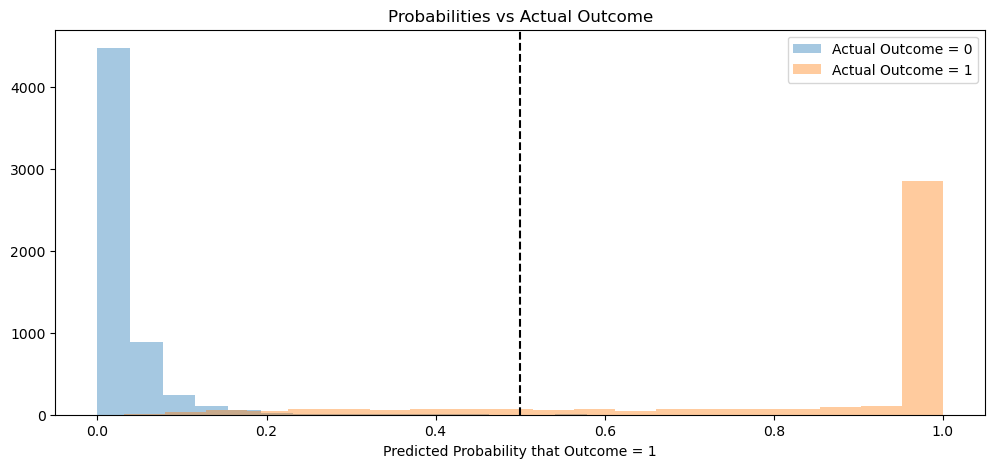

In [45]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_test_text.groupby('f1'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();
plt.title('Probabilities vs Actual Outcome')

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC Curve')

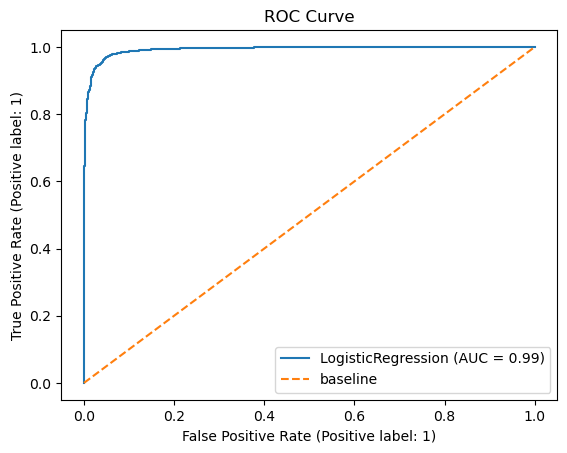

In [46]:
plot_roc_curve(M3, X1_test_all, y1_test_text)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();
plt.title('ROC Curve')

In [47]:
roc_auc_score(y1_test_text, M3.predict_proba(X1_test_all)[:,1])

0.9925762156023992

#### Checking ROC AUC for tweet prediction

In [48]:
prob_tweet=M3.predict_proba(X1_test_all_tweet)
prob_tweet

array([[9.40991577e-01, 5.90084225e-02],
       [7.39050282e-03, 9.92609497e-01],
       [5.18275655e-04, 9.99481724e-01],
       ...,
       [8.91498062e-02, 9.10850194e-01],
       [9.40386262e-01, 5.96137380e-02],
       [9.99481138e-01, 5.18861694e-04]])

In [49]:
df_test_tweet=pd.DataFrame({'f1': y1_test, 'prob': prob_tweet[:,1]})
df_test_tweet.head()

,f1,prob
13367,0,0.059008
2422,1,0.992609
3546,1,0.999482
5260,1,0.995466
7152,1,0.999893


/var/folders/3n/fkv2x4vs6_jc1rvhs53fssxr0000gn/T/ipykernel_2076/3155054182.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


Text(0.5, 1.0, 'Probabilities vs Actual Outcome')

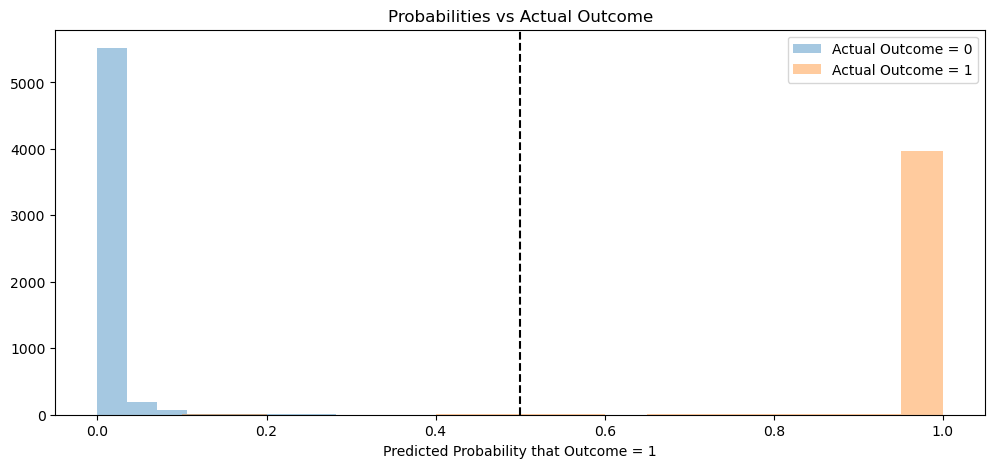

In [50]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_test_tweet.groupby('f1'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();
plt.title('Probabilities vs Actual Outcome')

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC Curve')

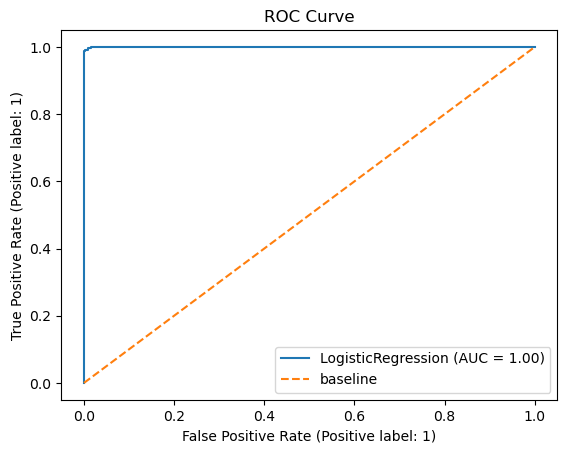

In [51]:
plot_roc_curve(M3, X1_test_all_tweet, y1_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();
plt.title('ROC Curve')

In [52]:
roc_auc_score(y1_test, M3.predict_proba(X1_test_all_tweet)[:,1])

0.9993859318845364

Looking at the probabilities vs actual outcome charts, there is potential to improve model performance further by adjusting to a lower threshold when classifying the tweets.

The high ROC AUC scores also shows that M3 is able to distinguish between tweets from Formula 1 and MotoGP well.

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9166498078090228
Recall: 0.8051307350764677
Precision: 0.9896907216494846
F1 Score: 0.8879216539717084


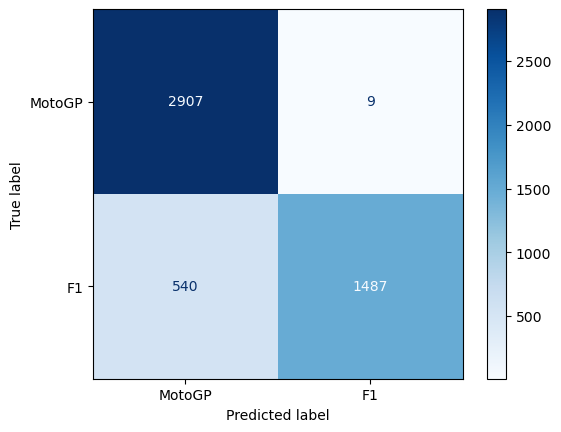

In [53]:
# Evaluate model on text-only tweets
evaluate_model(X1_test_all, y1_test_text, 0.4, M3)

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9401173376492009
Recall: 0.871238283177109
Precision: 0.9805663520266519
F1 Score: 0.922675026123302


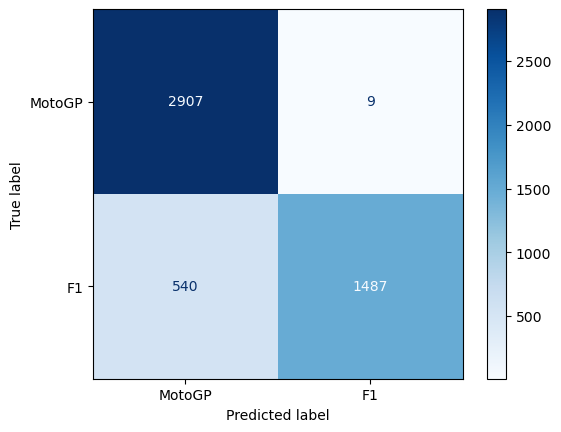

In [54]:
# Evaluate model on text-only tweets
evaluate_model(X1_test_all, y1_test_text, 0.3, M3)

Accuracy: 0.9945509586276489
Recall: 0.9896907216494846
Precision: 0.9970326409495549
F1 Score: 0.9933481152993349


/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


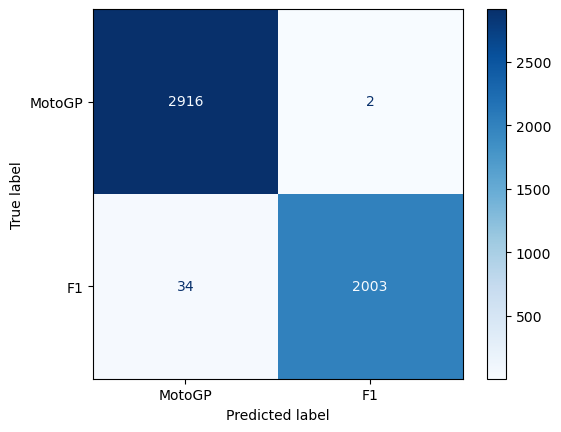

In [55]:
# Evaluate model on tweets
evaluate_model(X1_test_all_tweet, y1_test, 0.4, M3)

/opt/homebrew/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9935418768920282
Recall: 0.990672557682867
Precision: 0.9935992122107337
F1 Score: 0.9921337266470011


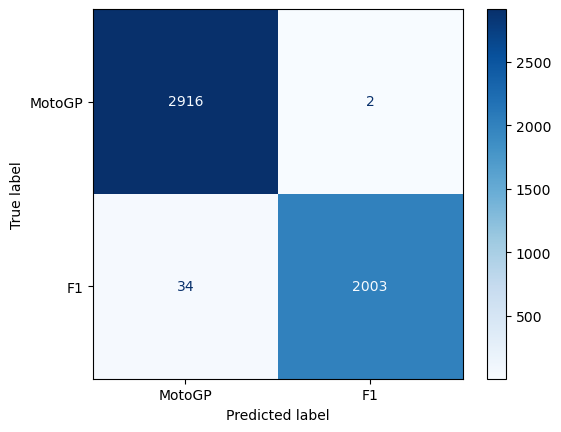

In [56]:
# Evaluate model on tweets
evaluate_model(X1_test_all_tweet, y1_test, 0.3, M3)

### Conclusion

Although our first model M1 showed high scores in terms of Accuracy and Recall, we need to bear in mind that the model was built and test on tweets from the official Twitter accounts of Formula 1 and MotoGP. The high scores were achieved primarily due to the hashtags which are prevalent in 97% of the tweets.

However, our aim is to build a classifier that is able to look at any tweet from any user, and determine if the tweet contains Formula 1 related content, so that we can push the tweet to the news feeds of users who are interested. Given that individual twitter accounts are unlikely to be as meticulous in including hastags, so we do need a model that can perform well when classifying tweets without any hashtag or mention. In this aspect, M1 only showed accuracy and recall rates of 77% and 45% respectively.

Hence, we would recommend to adopt M3 (with threshold 0.3), which is able to perform well on tweets both with and without hashtags.

|Model|Testing Accuracy|Recall|Precision|F1 Score|ROC AUC
|---|---|---|---|---|---|
|M1 (tweet-on-tweet)|0.992|0.980|0.999|0.990|--
|M1 (tweet-on-text)|0.772|0.453|0.980|0.620|--
|M2 (hashtag-on-hashtag)|0.991|0.978|1.000|0.989|--
|M3 (all-on-tweet, 0.5)|0.993|0.983|0.999|0.991|0.999
|M3 (all-on-text, 0.5)|0.889|0.734|0.994|0.844|0.993
|M3 (all-on-tweet, 0.4)|0.995|0.990|0.997|0.993|--
|M3 (all-on-text, 0.4)|0.917|0.805|0.987|0.888|--
|M3 (all-on-tweet, 0.3)|0.994|0.991|0.994|0.992|--
|M3 (all-on-text, 0.3)|0.940|0.871|0.981|0.923|--
